In [77]:
import yfinance as yfin
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

READ_FROM_CSV = True
SAVE_SCV = True

PATH_TO_CSV = 'AAPL.csv'

In [83]:
TICKER_NAME = 'AAPL'

start_date = '2022-10-18'
end_date = '2023-10-18'

In [89]:
if READ_FROM_CSV:
    df = pd.read_csv(PATH_TO_CSV)
    df = ticker_history.reset_index()
else:
    ticker = yfin.Ticker(TICKER_NAME)
    
    ticker_info = ticker.info
    
    ticker_history = ticker.history(interval='1d', start=start_date, end=end_date)
    
    df = ticker_history.reset_index()

    if SAVE_SCV:
        df.save(PATH_TO_CSV)

df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-10-18 00:00:00-04:00,144.631981,145.834836,139.780756,142.902237,99136600,0.0,0.0
1,2022-10-19 00:00:00-04:00,140.854396,144.095165,140.665514,143.011597,61758300,0.0,0.0
2,2022-10-20 00:00:00-04:00,142.176559,145.029629,141.808731,142.544373,64522000,0.0,0.0
3,2022-10-21 00:00:00-04:00,142.027429,146.978071,141.808725,146.401489,86548600,0.0,0.0
4,2022-10-24 00:00:00-04:00,146.321953,149.344018,145.138968,148.568619,75981900,0.0,0.0
...,...,...,...,...,...,...,...,...
246,2023-10-11 00:00:00-04:00,178.199997,179.850006,177.600006,179.800003,47551100,0.0,0.0
247,2023-10-12 00:00:00-04:00,180.070007,182.339996,179.039993,180.710007,56743100,0.0,0.0
248,2023-10-13 00:00:00-04:00,181.419998,181.929993,178.139999,178.850006,51427100,0.0,0.0
249,2023-10-16 00:00:00-04:00,176.750000,179.080002,176.509995,178.720001,52517000,0.0,0.0


In [90]:
df = df[df.columns[:-2]]
df

,Date,Open,High,Low,Close,Volume
0,2022-10-18 00:00:00-04:00,144.631981,145.834836,139.780756,142.902237,99136600
1,2022-10-19 00:00:00-04:00,140.854396,144.095165,140.665514,143.011597,61758300
2,2022-10-20 00:00:00-04:00,142.176559,145.029629,141.808731,142.544373,64522000
3,2022-10-21 00:00:00-04:00,142.027429,146.978071,141.808725,146.401489,86548600
4,2022-10-24 00:00:00-04:00,146.321953,149.344018,145.138968,148.568619,75981900
...,...,...,...,...,...,...
246,2023-10-11 00:00:00-04:00,178.199997,179.850006,177.600006,179.800003,47551100
247,2023-10-12 00:00:00-04:00,180.070007,182.339996,179.039993,180.710007,56743100
248,2023-10-13 00:00:00-04:00,181.419998,181.929993,178.139999,178.850006,51427100
249,2023-10-16 00:00:00-04:00,176.750000,179.080002,176.509995,178.720001,52517000


In [91]:
dates = df[df.columns[0]]
dates[0]

Timestamp('2022-10-18 00:00:00-0400', tz='America/New_York')

In [93]:
dates = df[df.columns[0]]
_dates = []
for idx, date in enumerate(dates):
    # dates[idx] = date.split()[0]
    _dates.append(date.strftime("%Y-%m-%d"))

df[df.columns[0]] = _dates
df.head()

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_78657/607492831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns[0]] = _dates


,Date,Open,High,Low,Close,Volume
0,2022-10-18,144.631981,145.834836,139.780756,142.902237,99136600
1,2022-10-19,140.854396,144.095165,140.665514,143.011597,61758300
2,2022-10-20,142.176559,145.029629,141.808731,142.544373,64522000
3,2022-10-21,142.027429,146.978071,141.808725,146.401489,86548600
4,2022-10-24,146.321953,149.344018,145.138968,148.568619,75981900


# Наложить на свечной график метки свечного паттерна Marubozu White/Back

In [94]:
def get_marobuzu(df: pd.DataFrame, epsilon: float, window: int):
    """
        Свечной паттерн Маробузу - находит свечи с длинным телом и без тени
        для этого одновременно проверяем:
        `High - Low = Open - Close + epsilon` и 
        `Open - Close > \frac{3}{2}\frac{1}{n}\Sigma_{i=1}^{n}|Open_i - Close_i|`, 
        где n - величина окна

        Аргументы:
            df, pandas.DataFrame - кадр данных со столбцами Open, Close, High, Low
            epsilon, float - пороговая разница между разницами цен открытия и закрытия и максимальной и минимальной
            window, int - величина окна, в котором рассчитывается маробузу

        Возвращаемое значение:
            marobuzu_vec, np.array - вектор паттернов маробузу, содержащий единицу в местах, где 
            паттерн имеет возбужденное состояние.
            
    """
    marobuzu_vec = np.zeros(len(df))
    open, close = df['Open'], df['Close']
    high, low = df['High'], df['Low']
    for i in range(window, df.shape[0]):
        indexes = np.arange(i-window, window, 1)
        diff = high[i] - low[i] - open[i] + close[i]
        tsum = np.abs(open[indexes] - close[indexes]).sum()*3./2./window
        if diff <= epsilon and open[i] - close[i] > tsum:
            marobuzu_vec[i] += 1
            
    return marobuzu_vec

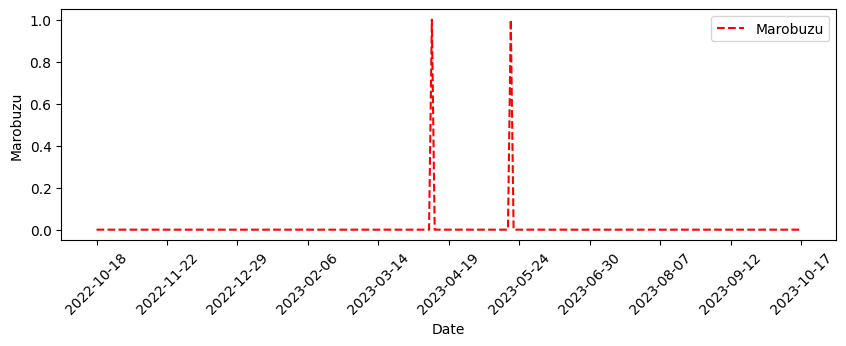

In [96]:
marobuzu = get_marobuzu(df, 0.3, 21)
dates = df[df.columns[0]]
plt.figure(figsize=(10,3))
plt.plot(df['Date'], marobuzu, 'r--', label='Marobuzu')
plt.xlabel('Date')
plt.ylabel('Marobuzu')
plt.xticks(np.arange(0, len(dates), 25), dates[np.arange(0, len(dates), 25)], rotation=45)
plt.legend()
plt.show()

In [97]:
marobuzu_points = marobuzu[np.where(marobuzu > 0, True, False)]
marobuzu_dates = dates[np.where(marobuzu > 0, True, False)]
pd.DataFrame({'Marobuzu': marobuzu_points, 'Date': marobuzu_dates})

,Marobuzu,Date
119,1.0,2023-04-11
147,1.0,2023-05-19


In [98]:
start_epsilon = 0
end_epsilon = 0.3
step = 0.0005 * df['Close'].values[-1]
step

0.0885749969482422

In [103]:
np.arange(start_epsilon, end_epsilon, step)

array([0.        , 0.088575  , 0.17714999, 0.26572499])

In [106]:
np.linspace(start_epsilon, end_epsilon, round((end_epsilon - start_epsilon)/step)+1)

array([0. , 0.1, 0.2, 0.3])